In [1]:
import numpy as np
import pandas as pd
import os
import openpyxl
import tensorflow as tf
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from pandas import concat
from tensorflow.keras.layers import LSTM,Dense,GRU,Dropout,SimpleRNN
from sklearn.metrics import mean_squared_error
# from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
n_hours = 5
n_features = 43
train_num_24 = 2789
train_num_25 = 2892
train_num_19 = 1934

In [4]:
from os.path import join
df = pd.read_excel('rain_data.xlsx')
df.head()

,홍수사상번호,연,월,일,시간,유입량,데이터집단 1,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 38,Unnamed: 39,Unnamed: 40,데이터 집단 6,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47
0,1,2006,7,10,8,189.100000,6.4,7,7,7,...,8,2.54,122.660,6.4,7,7,8,8,2.54,122.610
1,1,2006,7,10,9,216.951962,6.3,7,8,7,...,10,2.53,122.648,7.3,7,8,10,10,2.53,122.600
2,1,2006,7,10,10,251.424419,6.4,7,9,7,...,11,2.53,122.636,8.2,7,9,10,11,2.53,122.590
3,1,2006,7,10,11,302.812199,7.3,7,10,7,...,14,2.53,122.620,11.3,9,10,15,14,2.53,122.585
4,1,2006,7,10,12,384.783406,8.2,7,12,8,...,16,2.53,122.604,14.4,12,12,18,16,2.53,122.575


In [5]:
# df_metrix 만드는 과정
df_matrix = df.to_numpy()
df_matrix = df_matrix[0:train_num_25, 5:]
print(df_matrix)

df_matrix = df_matrix.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
df_matrix = scaler.fit_transform(df_matrix)

df_matrix

[[189.1         6.4         7.        ...   8.          2.54
  122.61     ]
 [216.9519618   6.3         7.        ...  10.          2.53
  122.6      ]
 [251.4244187   6.4         7.        ...  11.          2.53
  122.59     ]
 ...
 [481.1030831   3.3854      1.        ...   1.          2.96
  137.165    ]
 [470.4581089   3.2841      1.        ...   1.          2.94
  137.18     ]
 [        nan  14.2576     32.        ...   0.          1.93
  120.515    ]]


array([[0.0086303 , 0.01948843, 0.0212766 , ..., 0.03065134, 0.09392971,
        0.15531301],
       [0.00992569, 0.01918392, 0.0212766 , ..., 0.03831417, 0.09329073,
        0.15491581],
       [0.01152899, 0.01948843, 0.0212766 , ..., 0.04214559, 0.09329073,
        0.1545186 ],
       ...,
       [0.02221129, 0.01030877, 0.00303951, ..., 0.00383142, 0.12076677,
        0.7334657 ],
       [0.0217162 , 0.0100003 , 0.00303951, ..., 0.00383142, 0.11948882,
        0.73406124],
       [       nan, 0.04341535, 0.09726444, ..., 0.        , 0.05495208,
        0.07209539]], dtype=float32)

In [6]:
# print(df_matrix)
lag = series_to_supervised(df_matrix, n_hours,1)

lag = lag.values

tmp = lag.shape[1]-42

lag = lag[:,0:tmp]
print(lag.shape)

(2886, 216)


In [7]:
n_train_hours = train_num_19
train = lag[:n_train_hours, :]
test = lag[n_train_hours:, :]

In [8]:
##1
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1934, 215) 1934 (1934,)
(1934, 5, 43) (1934,) (952, 5, 43) (952,)


In [9]:
#testing
model = tf.keras.Sequential()
model.add(GRU(units = 50,
              # dropout =0.2,
              return_sequences = True,
              input_shape = (train_X.shape[1],train_X.shape[2]),
              activation = 'tanh'))

model.add(SimpleRNN(50))

model.add(Dense(1))

2021-08-26 15:36:48.056659: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-08-26 15:36:48.073873: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fde86d1a2e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-26 15:36:48.073890: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [10]:
# # optimizer =tf.train.AdamOptimizer(lea)
adam = tf.keras.optimizers.Adam(lr =0.01)
# early_stop = EarlyStopping(monitor='val_loss', patience=5)
# filename = os.path.join(model_path, 'tmp_checkpoint.h5')
# checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

model.compile(loss='mse', optimizer='adam')

# history = model.fit(train_X, train_y, 
#                                     epochs=100, 
#                                     batch_size=16,
#                                     validation_data=(test_X, test_y), 
#                                     callbacks=[early_stop, checkpoint])
history = model.fit(train_X, train_y, 
                                    epochs=100, 
                                    batch_size=16,
                                    validation_data=(test_X, test_y))

pred = model.predict(test_X)

Epoch 1/100
121/121 [==============================] - 1s 8ms/step - loss: 0.0149 - val_loss: 5.7397e-04
Epoch 2/100
121/121 [==============================] - 1s 6ms/step - loss: 7.6949e-04 - val_loss: 5.1252e-04
Epoch 3/100
121/121 [==============================] - 1s 5ms/step - loss: 3.9483e-04 - val_loss: 2.8636e-04
Epoch 4/100
121/121 [==============================] - 1s 5ms/step - loss: 3.2768e-04 - val_loss: 5.9066e-04
Epoch 5/100
121/121 [==============================] - 1s 7ms/step - loss: 2.9207e-04 - val_loss: 1.6743e-04
Epoch 6/100
121/121 [==============================] - 1s 8ms/step - loss: 2.4085e-04 - val_loss: 1.3070e-04
Epoch 7/100
121/121 [==============================] - 1s 6ms/step - loss: 1.9483e-04 - val_loss: 1.1094e-04
Epoch 8/100
121/121 [==============================] - 1s 4ms/step - loss: 2.1804e-04 - val_loss: 1.5543e-04
Epoch 9/100
121/121 [==============================] - 1s 4ms/step - loss: 1.4908e-04 - val_loss: 8.3918e-05
Epoch 10/100
121/121 [=

121/121 [==============================] - 1s 5ms/step - loss: 3.7465e-05 - val_loss: 2.8761e-05
Epoch 76/100
121/121 [==============================] - 1s 4ms/step - loss: 4.1082e-05 - val_loss: 2.3503e-05
Epoch 77/100
121/121 [==============================] - 1s 5ms/step - loss: 3.2170e-05 - val_loss: 2.4703e-05
Epoch 78/100
121/121 [==============================] - 1s 5ms/step - loss: 5.3529e-05 - val_loss: 4.9639e-05
Epoch 79/100
121/121 [==============================] - 1s 5ms/step - loss: 3.0603e-05 - val_loss: 2.0625e-05
Epoch 80/100
121/121 [==============================] - 1s 5ms/step - loss: 1.2007e-05 - val_loss: 1.1273e-05
Epoch 81/100
121/121 [==============================] - 1s 5ms/step - loss: 4.6607e-05 - val_loss: 1.1802e-05
Epoch 82/100
121/121 [==============================] - 1s 5ms/step - loss: 9.7458e-06 - val_loss: 7.2818e-06
Epoch 83/100
121/121 [==============================] - 1s 6ms/step - loss: 1.0314e-05 - val_loss: 3.6648e-05
Epoch 84/100
121/121 [=

In [11]:
'''
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(train_X, train_y, 
                                    epochs=100, 
                                    batch_size=16,
                                    validation_data=(test_X, test_y), 
                                    callbacks=[early_stop, checkpoint])

model.load_weights(filename)
pred = model.predict(test_X)

pred.shape
'''

"\nmodel.compile(loss='mean_squared_error', optimizer='adam')\nearly_stop = EarlyStopping(monitor='val_loss', patience=5)\nmodel_path = 'model'\nfilename = os.path.join(model_path, 'tmp_checkpoint.h5')\ncheckpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')\n\nhistory = model.fit(train_X, train_y, \n                                    epochs=100, \n                                    batch_size=16,\n                                    validation_data=(test_X, test_y), \n                                    callbacks=[early_stop, checkpoint])\n\nmodel.load_weights(filename)\npred = model.predict(test_X)\n\npred.shape\n"

In [12]:
RMSE = mean_squared_error(test_y,pred)**0.5
print(RMSE)

0.004627265128089548


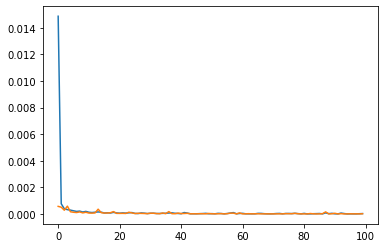

In [13]:
plt.plot(history.history['loss'],label = 'train')
plt.plot(history.history['val_loss'], label = 'test')

plt.show()

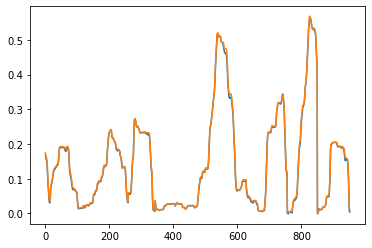

In [14]:
plt.plot(pred,label='prediction')
plt.plot(test_y,label='real')
plt.show()